In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

# import time
# from numba import jit, njit

from pprint import pprint
from rouge import Rouge

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional
from keras.optimizers import Adam, Nadam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
import tensorflow
np.__version__

'1.20.2'

In [3]:
# !pip install numpy==1.20.2

In [4]:
# !pip uninstall numpy -y

In [5]:
df = pd.read_csv('../data/wikihowAll_cleaned.csv', delimiter=',')

In [6]:
df.head()

,headline,text
0,keep related supplies in the same area make an...,photographer keep necessary lens cord battery ...
1,create a sketch in the neopoprealist manner of...,see image draw develops stepbystep however imp...
2,get a bachelors degree enroll in a studiobased...,possible become vfx artist without college deg...
3,start with some experience or interest in art ...,best art investor research piece art buy someo...
4,keep your reference materials sketches article...,start planning project work shall likely gathe...


Розділимо датасет на тренувальний, тестувальний і валідаційний

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(df, test_size=0.10, random_state=42, shuffle=True)

In [9]:
train, val = train_test_split(train, test_size=0.11, random_state=42, shuffle=True)

In [10]:
train.shape

(1593, 2)

In [11]:
test.shape

(199, 2)

In [12]:
val.shape

(197, 2)

In [13]:
def calc_vocab(texts) :
    vocab = [] 
    for text in texts:
        words = text.split()
        for w in words:          
            if w not in vocab:
                vocab.append(w)
    return len(vocab)

In [14]:
vocab = calc_vocab(train['text'])

In [15]:
vocab

18299

In [16]:
maxlen = 150
embed_dim = 120
batch_size = 32
latent_dim = 200

In [17]:
tokenizer = Tokenizer(num_words=vocab)
tokenizer.fit_on_texts(train['text'])
seqs = tokenizer.texts_to_sequences(train['text'])
pad_seqs = pad_sequences(seqs, maxlen)

seqs_val = tokenizer.texts_to_sequences(val['text'])
pad_seqs_val = pad_sequences(seqs_val, maxlen)

In [18]:
encoder_inputs = Input(shape=(maxlen,))
emb_layer = Embedding(vocab, embed_dim, input_length = maxlen)
x = emb_layer(encoder_inputs)
encoder_lstm_1 = LSTM(latent_dim, activation='relu', return_sequences=True, dropout=0.2)(x)
encoder_lstm_2 = LSTM(latent_dim, activation='relu', return_sequences=True, dropout=0.2)(encoder_lstm_1)
state_h = LSTM(latent_dim, activation='relu')(encoder_lstm_2)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h)
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [19]:
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_lstm = LSTM(latent_dim, return_sequences=True)
decoder_lstm_output = decoder_lstm(decoded)
decoder_dense = Dense(vocab, activation='softmax')#TimeDistributed
decoder_outputs = decoder_dense(decoder_lstm_output)

In [20]:
seq2seq_Model = Model(encoder_inputs, decoder_outputs)
seq2seq_Model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
model_1 (Model)              (None, 200)               3094280   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 150, 200)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 200)          320800    
_________________________________________________________________
dense_1 (Dense)              (None, 150, 18299)        3678099   
Total params: 7,093,179
Trainable params: 7,093,179
Non-trainable params: 0
_________________________________________________________________


In [21]:
seq2seq_Model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   verbose = 1,
                   patience = 2)

mc = ModelCheckpoint('best_model.h5',
                    monitor = 'val_loss',
                    mode = 'min',
                    verbose = 1,
                    save_best_only = True)

In [22]:
pad_seqs.shape

(1593, 150)

In [22]:
history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1), 
                            batch_size=64, 
                            callbacks = [es, mc],
                            epochs=15,
                            validation_data = (pad_seqs_val, np.expand_dims(pad_seqs_val, -1)))

/home/maksboruh/my_project_env/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 1593 samples, validate on 197 samples
Epoch 1/15
1593/1593 [==============================] - 91s 57ms/step - loss: 8.4885 - val_loss: 7.5910

Epoch 00001: val_loss improved from inf to 7.59097, saving model to best_model.h5
Epoch 2/15
1593/1593 [==============================] - 89s 56ms/step - loss: 7.4297 - val_loss: 7.0356

Epoch 00002: val_loss improved from 7.59097 to 7.03556, saving model to best_model.h5
Epoch 3/15
1593/1593 [==============================] - 89s 56ms/step - loss: 7.0809 - val_loss: 6.7847

Epoch 00003: val_loss improved from 7.03556 to 6.78467, saving model to best_model.h5
Epoch 4/15
1593/1593 [==============================] - 89s 56ms/step - loss: 6.9198 - val_loss: 6.6972

Epoch 00004: val_loss improved from 6.78467 to 6.69723, saving model to best_model.h5
Epoch 5/15
1593/1593 [==============================] - 89s 56ms/step - loss: 6.8866 - val_loss: 6.6940

Epoch 00005: val_loss improved from 6.69723 to 6.69398, saving model to best_model.h5
Ep

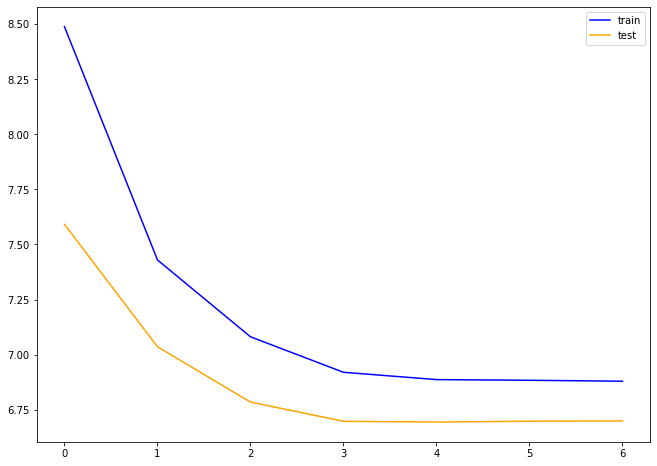

In [23]:
from matplotlib import pyplot
pyplot.figure(figsize = (11,8))
pyplot.plot(history.history['loss'], label = 'train', color = 'blue')
pyplot.plot(history.history['val_loss'], label = 'test', color = 'orange')

pyplot.legend()
pyplot.show()

In [24]:
def get_scores_rouge(text, prediction):
    rouge = Rouge()
    scores = rouge.get_scores(prediction, text)
    return scores

In [25]:
def get_predicted_text(text, maxlen=maxlen):
    seqs = tokenizer.texts_to_sequences([text])
    pad_seqs = pad_sequences(seqs, maxlen)
    res = seq2seq_Model.predict(pad_seqs)
    ty = tokenizer.sequences_to_texts(pad_seqs)
    rr = ' '.join(ty)
    return rr

In [26]:
pred = get_predicted_text(list(test['text'])[0])

In [27]:
pred

'aroma likely persist bother hamster wash food water equipment way sure rinse food water equipment extra time want soap residue get anything hamster consume diligent cleaning every single spot cage instance hamster likely urinates defecates particular location pay extra attention cleaning area wash everything antibacterial soap warm water rinse allow fully dry ensure cage still smell soap rinse necessary follow mite infestation youll need second cleaning disinfect surface hamster dwell rub rub alcohol surface cage plastic metal climb structure dry surface clean paper care avoid apply rub alcohol food water equipment replace anything unable clean wooden toy particular replace frequently make sure water bottle leak finally make sure fasten component cage structure also secure mite prevent return maintain clean living environment hamster prevent hamster become stress sure provide ample high quality food hamster proper nutrition also decrease likelihood mite specific information regard ham

In [28]:
list(test['text'])[0]

'likely culprit uncleanliness hamster cage location mite likely living old bedding set clean cage first step remove bedding dispose outdoor trash receptacle take everything cage take apart remove lid feed dish water bottle toy tube ladder furnishing anything plastic metal wash antibacterial soap warm water thoroughly rinse allow fully dryopt unscented antibacterial soap aroma likely persist bother hamster wash food water equipment way sure rinse food water equipment extra time want soap residue get anything hamster consume diligent cleaning every single spot cage instance hamster likely urinates defecates particular location pay extra attention cleaning area wash everything antibacterial soap warm water rinse allow fully dry ensure cage still smell soap rinse necessary follow mite infestation youll need second cleaning disinfect surface hamster dwell rub rub alcohol surface cage plastic metal climb structure dry surface clean paper toweltake care avoid apply rub alcohol food water equi

In [29]:
pprint(get_scores_rouge(list(test['text'])[0], pred))

[{'rouge-1': {'f': 0.8403361295812443, 'p': 1.0, 'r': 0.7246376811594203},
  'rouge-2': {'f': 0.8169014035796074,
              'p': 0.9731543624161074,
              'r': 0.7038834951456311},
  'rouge-l': {'f': 0.8849557472785654, 'p': 1.0, 'r': 0.7936507936507936}}]


In [30]:
pred = get_predicted_text(list(train['text'])[0])

In [31]:
pred

'family name could include traditional name family generation mother maiden name name decease relative many people give pet name like prince princess allude royalty name reflect important new pet life example regal formal name include queen queenie king duke duchess lady unusual rare outdated name often perfect pet name unique often funny quirky way especially traditional formal example unusual name male guinea pig include boris geoffrey harold fabio example unusual female name wanda beatrice harriet sabrina think favorite figure history often make great pet name give pet unique tie history association name provoke often humorous light adorable fluffy pet could name male guinea pig moses hamlet napoleon dante could name female guinea pig cleopatra athena marilyn think favorite fictional character book movie enjoy pick name fictional character great way combine two thing love could name male guinea pig sherlock ichabod atticus could name female guinea pig hermione scarlett pippi katniss

In [32]:
list(train['text'])[0]

'guinea pig new addition family make sense give pet family name family name could include traditional name family generation mother maiden name name decease relative many people give pet name like prince princess allude royalty name reflect important new pet life example regal formal name include queen queenie king duke duchess lady unusual rare outdated name often perfect pet name unique often funny quirky way especially traditional formal example unusual name male guinea pig include boris geoffrey harold fabio example unusual female name wanda beatrice harriet sabrina think favorite figure history often make great pet name give pet unique tie history association name provoke often humorous light adorable fluffy pet could name male guinea pig moses hamlet napoleon dante could name female guinea pig cleopatra athena marilyn think favorite fictional character book movie enjoy pick name fictional character great way combine two thing love could name male guinea pig sherlock ichabod attic

In [33]:
pprint(get_scores_rouge(list(train['text'])[0], pred))

[{'rouge-1': {'f': 0.964630220086641, 'p': 1.0, 'r': 0.9316770186335404},
  'rouge-2': {'f': 0.9644012895047184, 'p': 1.0, 'r': 0.93125},
  'rouge-l': {'f': 0.9891304297831995, 'p': 1.0, 'r': 0.978494623655914}}]


In [34]:
def rouge_min(texts, rouge, metric):
    min_s = np.inf
    for text in texts:
        score = get_scores_rouge(text, get_predicted_text(text))[0].get(rouge).get(metric)
        if score < min_s:
            min_s = score
    return min_s

In [35]:
rouge_min(list(test['text']), 'rouge-l', 'p')

1.0

In [36]:
rouge_min(list(test['text']), 'rouge-l', 'r')

0.17801047120418848

In [37]:
rouge_min(list(test['text']), 'rouge-l', 'f')

0.3022222196566914